In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras import utils

# 進度條模組
from tqdm import tqdm
%matplotlib inline

In [2]:
#檢測tensorflow gpu是否啟用
tf.config.list_physical_devices("GPU")
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'#选择哪一块gpu
config = ConfigProto()
# config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
# config.gpu_options.per_process_gpu_memory_fraction=0.5 #分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
config.gpu_options.allow_growth = True #按需分配显存，这个比较重要
session = InteractiveSession(config=config)

# Load Data

In [4]:
# 8種類
class_names = ['normal' , 'lint' , 'error_ear' , 'error_iron' , 'error_solder' , 'noearing' , 'noiron' , 'NG']

class_names_label = {class_name:i for i,class_name in enumerate(class_names)}
print(class_names_label)

nb_classes = len(class_names)

IMAGE_SIZE = (108 , 192)

{'normal': 0, 'lint': 1, 'error_ear': 2, 'error_iron': 3, 'error_solder': 4, 'noearing': 5, 'noiron': 6, 'NG': 7}


In [5]:
datasets = ['E:/mask_data/insta/test']    
for dataset in datasets:
    images = []
    labels = []
        
    print('Loading{}'.format(dataset))
        
    for folder in os.listdir(dataset):
        label = class_names_label[folder]
            
        for file in tqdm(os.listdir(os.path.join(dataset , folder))):
                
            img_path = os.path.join(os.path.join(dataset , folder), file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image , IMAGE_SIZE)
            # 邊緣
            sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0)
            sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1)
            sobelX = np.uint8(np.absolute(sobelX))
            sobelY = np.uint8(np.absolute(sobelY))
            sobelCombined = cv2.bitwise_or(sobelX, sobelY)
            images.append(sobelCombined)

#             images.append(image)
            labels.append(label)
                
    images = np.array(images , dtype = 'float32')
    labels = np.array(labels , dtype = 'int32')
    labels = utils.to_categorical(labels , 8 , dtype = 'int32')

  5%|███▉                                                                              | 5/104 [00:00<00:02, 43.44it/s]

LoadingE:/mask_data/insta/test


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 44.72it/s]


In [6]:
from tensorflow.keras import utils
test_images = images
test_labels = labels
print(test_images.shape)
print(test_labels.shape)

(723, 192, 108)
(723, 8)


In [7]:
from sklearn.utils import shuffle           

test_images, test_labels = shuffle(test_images, test_labels, random_state = 25)

In [8]:
# check how many training and testing example do we have
# check the size of image
n_test = test_labels.shape[0]

print('Number of testing example : {}'.format(n_test))
print('Each image is of size : {}'.format(IMAGE_SIZE))

Number of testing example : 723
Each image is of size : (108, 192)


In [9]:
test_images = test_images / 255.0

In [10]:
test_images = tf.expand_dims(test_images, axis=-1)

# Load Model

In [11]:
# Edge
# ## B0~B7
# model_file = ['Mask-Edge-EfficientNetB0.h5' , 'Mask-Edge-EfficientNetB1.h5' , 'Mask-Edge-EfficientNetB2.h5' , 
#               'Mask-Edge-EfficientNetB3.h5' , 'Mask-Edge-EfficientNetB4.h5' , 'Mask-Edge-EfficientNetB5.h5' , 
#               'Mask-Edge-EfficientNetB6.h5' , 'Mask-Edge-EfficientNetB7.h5']

# ## B0 B1 B2 B4 B5 B6 B7
# model_file = ['Mask-Edge-EfficientNetB0.h5' , 'Mask-Edge-EfficientNetB1.h5' , 'Mask-Edge-EfficientNetB2.h5' , 
#               'Mask-Edge-EfficientNetB4.h5' ,'Mask-Edge-EfficientNetB5.h5' , 'Mask-Edge-EfficientNetB6.h5' , 
#               'Mask-Edge-EfficientNetB7.h5']

# ## B0 B2 B5 B6 B7
# model_file = ['Mask-Edge-EfficientNetB0.h5' , 'Mask-Edge-EfficientNetB2.h5' , 'Mask-Edge-EfficientNetB5.h5' , 
#               'Mask-Edge-EfficientNetB6.h5' , 'Mask-Edge-EfficientNetB7.h5']

## B0 B2 B6
model_file = ['Mask-Edge-EfficientNetB0.h5' ,  'Mask-Edge-EfficientNetB2.h5' , 'Mask-Edge-EfficientNetB6.h5']


# # No Edge
# ## B0~B7
# model_file = ['Mask-NOEdge-EfficientNetB0.h5' , 'Mask-NOEdge-EfficientNetB1.h5' , 'Mask-NOEdge-EfficientNetB2.h5' , 
#               'Mask-NOEdge-EfficientNetB3.h5' , 'Mask-NOEdge-EfficientNetB4.h5' , 'Mask-NOEdge-EfficientNetB5.h5' , 
#               'Mask-NOEdge-EfficientNetB6.h5' , 'Mask-NOEdge-EfficientNetB7.h5']

# ## B0 B2 B3 B4 B5 B6 B7
# model_file = ['Mask-NOEdge-EfficientNetB0.h5' , 'Mask-NOEdge-EfficientNetB2.h5' , 'Mask-NOEdge-EfficientNetB3.h5' , 
#               'Mask-NOEdge-EfficientNetB4.h5' , 'Mask-NOEdge-EfficientNetB5.h5' , 'Mask-NOEdge-EfficientNetB6.h5' , 
#               'Mask-NOEdge-EfficientNetB7.h5']

# ## B0 B4 B5 B6 B7
# model_file = ['Mask-NOEdge-EfficientNetB0.h5' , 'Mask-NOEdge-EfficientNetB4.h5' , 'Mask-NOEdge-EfficientNetB5.h5' , 
#               'Mask-NOEdge-EfficientNetB6.h5' , 'Mask-NOEdge-EfficientNetB7.h5']

# # B4 B5 B6
# model_file = ['Mask-NOEdge-EfficientNetB4.h5' , 'Mask-NOEdge-EfficientNetB5.h5' , 'Mask-NOEdge-EfficientNetB6.h5' ]

In [12]:
# model = tf.keras.models.load_model('best model/Edge/'+'Mask-Edge-EfficientNetB0.h5')
# model.name

In [13]:
models = []
for model in model_file:
    model = tf.keras.models.load_model('best model/Edge/'+model)
    models.append(model)
    
# for model in model_file:
#     model = tf.keras.models.load_model('best model/NoEdge/'+model)
#     models.append(model)

# check model

In [14]:
for model in models:
    print(model.name)

EfficientNetB0-Edge
EfficientNetB2-Edge
EfficientNetB6-Edge


# Evaluation data

In [15]:
for model in models:
    model.evaluate(test_images, test_labels, batch_size=128)

6/6 [==============================] - 8s 672ms/step - loss: 0.5986 - accuracy: 0.9225


# Predict data

In [16]:
labels = np.argmax(test_labels, axis = 1) 
labels

array([1, 3, 0, 7, 7, 3, 4, 0, 7, 7, 7, 5, 0, 3, 1, 3, 2, 2, 4, 0, 2, 7,
       7, 2, 7, 7, 4, 7, 3, 2, 3, 0, 3, 3, 5, 7, 2, 3, 3, 7, 0, 4, 0, 3,
       2, 0, 2, 1, 7, 7, 3, 1, 4, 7, 4, 7, 4, 0, 2, 7, 4, 5, 7, 3, 7, 2,
       5, 1, 5, 0, 1, 5, 1, 3, 0, 2, 7, 3, 5, 0, 0, 0, 3, 5, 3, 0, 0, 7,
       0, 3, 2, 6, 5, 6, 0, 4, 0, 3, 6, 2, 2, 4, 7, 3, 3, 2, 4, 4, 2, 4,
       6, 2, 3, 3, 4, 4, 7, 7, 3, 2, 0, 3, 7, 0, 3, 3, 3, 4, 2, 0, 7, 1,
       2, 7, 6, 3, 3, 5, 7, 1, 3, 4, 2, 4, 3, 3, 5, 5, 3, 3, 3, 2, 0, 7,
       3, 1, 4, 1, 0, 4, 2, 4, 5, 7, 4, 6, 7, 1, 4, 4, 7, 5, 2, 3, 3, 3,
       4, 5, 4, 1, 5, 3, 3, 1, 3, 5, 1, 7, 0, 6, 3, 3, 0, 2, 1, 5, 2, 6,
       5, 1, 0, 3, 5, 0, 3, 4, 5, 0, 7, 7, 4, 3, 2, 3, 1, 3, 3, 3, 7, 0,
       4, 4, 5, 7, 3, 4, 5, 4, 4, 3, 7, 1, 7, 1, 2, 7, 2, 7, 7, 4, 7, 3,
       2, 4, 3, 4, 1, 0, 2, 2, 2, 2, 1, 3, 2, 3, 5, 0, 3, 1, 7, 2, 4, 3,
       1, 1, 7, 6, 4, 3, 5, 4, 2, 0, 2, 7, 4, 5, 7, 4, 7, 7, 3, 6, 0, 3,
       0, 3, 7, 1, 2, 0, 3, 4, 2, 2, 5, 2, 1, 3, 6,

In [17]:
y_predictions_All = []
for model in models:
    y_predictions = model.predict(test_images)
    y_predictions_All.append(y_predictions)

In [18]:
y_predictions_ensemble = y_predictions_All[0]+y_predictions_All[1]+y_predictions_All[2]
y_predictions_ensemble.shape

(723, 8)

In [19]:
predicts_ensemble=np.argmax(y_predictions_ensemble,axis=1)

# confusion_matrix

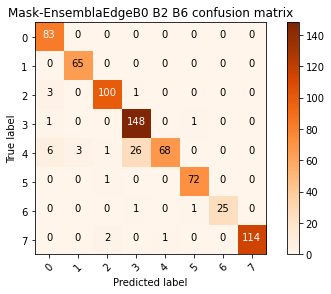

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Mask-EnsemblaEdgeB0 B2 B6 confusion matrix'
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('E://Mask_confusion//Mask-EnsemblaNoEdgeB4 B5 B6.jpg')
    plt.show()


confusion_mtx = confusion_matrix(labels, predicts_ensemble)
plot_confusion_matrix(confusion_mtx, classes = range(8))

In [21]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(labels, predicts_ensemble)))

Accuracy : 0.9336099585062241
